# XGBoost Popularity Classifier
### Predict Track Popularity Ranges (Low/Medium/High)

In [1]:
# Data Preparation 

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# load and clean data 
df = pd.read_csv("spotify_tracks.csv")

# feature engineering
df['duration_min'] = df['duration_ms'] / 60000
df['artist_popularity'] = df.groupby('artists')['popularity'].transform('mean')

# create target classes
df['popularity_level'] = pd.cut(df['popularity'],
                                bins=[0, 40, 70, 100],
                                labels=['Low', 'Medium', 'High'],
                                include_lowest=True)

# Remove rows with NaN in target or features
df = df.dropna(subset=['popularity_level', 'duration_min', 'artist_popularity', 'explicit'])

# Verify no NaN remains
print("Remaining NaN counts:")
print(df.isna().sum())

# select features
features = ['duration_min', 'explicit', 'artist_popularity']
X = df[features]
y = df['popularity_level']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Remaining NaN counts:
id                   0
name                 0
genre                0
artists              0
album                0
popularity           0
duration_ms          0
explicit             0
duration_min         0
artist_popularity    0
popularity_level     0
dtype: int64


In [2]:
# Preprocessing Pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# numeric preprocessing
numeric_features = ['duration_min', 'artist_popularity']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# categorical preprocessing
categorical_features = ['explicit']
categorical_transformer = Pipeline(steps=[
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

# combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
## XGBoost Model Training 

import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Label Encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Create validation set from training data
X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

# Build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        n_estimators=200,
        early_stopping_rounds=10,
        random_state=42
    ))
])

# Preprocess validation data for early stopping
preprocessor.fit(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

# Train with validation set
model.fit(X_train, y_train_encoded,
          classifier__eval_set=[(X_val_preprocessed, y_val_encoded)],
          classifier__verbose=True
)

[0]	validation_0-mlogloss:0.76402
[1]	validation_0-mlogloss:0.57717
[2]	validation_0-mlogloss:0.46005
[3]	validation_0-mlogloss:0.38414
[4]	validation_0-mlogloss:0.33378
[5]	validation_0-mlogloss:0.29953
[6]	validation_0-mlogloss:0.27635
[7]	validation_0-mlogloss:0.25998
[8]	validation_0-mlogloss:0.24828
[9]	validation_0-mlogloss:0.24082
[10]	validation_0-mlogloss:0.23384
[11]	validation_0-mlogloss:0.23059
[12]	validation_0-mlogloss:0.22638
[13]	validation_0-mlogloss:0.22411
[14]	validation_0-mlogloss:0.22204
[15]	validation_0-mlogloss:0.22114
[16]	validation_0-mlogloss:0.22082
[17]	validation_0-mlogloss:0.22142
[18]	validation_0-mlogloss:0.22169
[19]	validation_0-mlogloss:0.22218
[20]	validation_0-mlogloss:0.22189
[21]	validation_0-mlogloss:0.22192
[22]	validation_0-mlogloss:0.22252
[23]	validation_0-mlogloss:0.22343
[24]	validation_0-mlogloss:0.22415
[25]	validation_0-mlogloss:0.22392
[26]	validation_0-mlogloss:0.22392


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration_min',
                                                   'artist_popularity']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['explicit'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsamp...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None, num_class=3,
                               num_parallel_tree=None, ...))])

Classification Report:
              precision    recall  f1-score   support

        High       0.90      0.55      0.68        33
         Low       0.96      0.96      0.96       872
      Medium       0.88      0.91      0.89       355

    accuracy                           0.94      1260
   macro avg       0.91      0.81      0.84      1260
weighted avg       0.94      0.94      0.94      1260



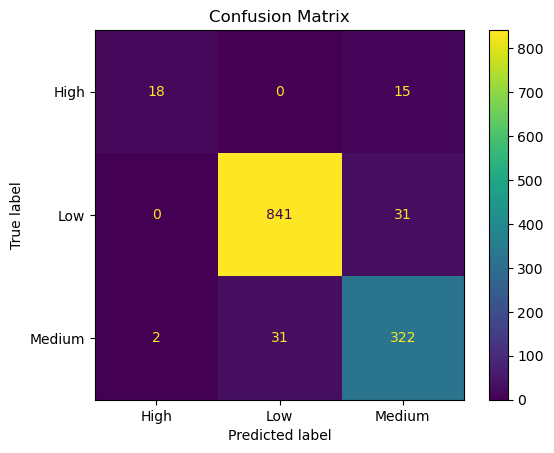

In [9]:
## model evaluation

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Preprocess test data
X_test_preprocessed = preprocessor.transform(X_test)

# Predictions
y_pred_encoded = model.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=le.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

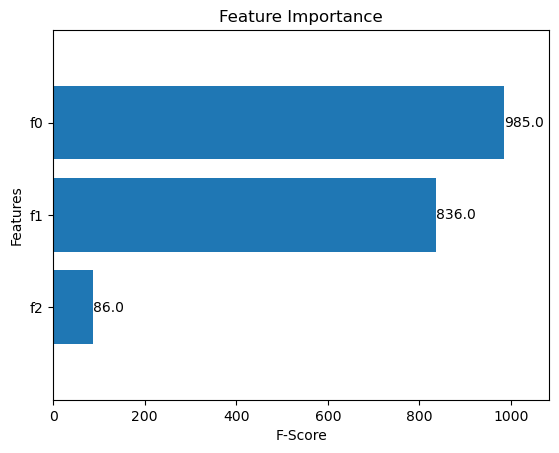

In [10]:
# feature importance 

# Get feature names
feature_names = (numeric_features + 
                list(model.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features)))

# Plot importance
xgb.plot_importance(model.named_steps['classifier'],
                   height=0.8,
                   max_num_features=10,
                   title="Feature Importance",
                   xlabel="F-Score",
                   ylabel="Features",
                   importance_type='weight',
                   grid=False)
plt.show()

In [11]:
## prediction testing 

def predict_popularity(duration_min, explicit, artist_pop):
    """Test the model with custom inputs"""
    input_data = pd.DataFrame({
        'duration_min': [duration_min],
        'explicit': [explicit],
        'artist_popularity': [artist_pop]
    })
    return model.predict(input_data)[0]

# Test cases
print(predict_popularity(3.5, True, 85))   # Likely "High"
print(predict_popularity(6.0, False, 35))  # Likely "Low"

0
1


In [12]:
import joblib

# Save model
joblib.dump(model, 'spotify_pop_predictor.joblib')

# Load later with:
# loaded_model = joblib.load('spotify_pop_predictor.joblib')

['spotify_pop_predictor.joblib']